#
Ref https://www.frontiersin.org/articles/10.3389/fpsyt.2021.707581/full

In [ ]:
!pip install -q catboost
!pip install -q lightgbm
!pip install -q xgboost
!pip install -q mne
!pip install -q scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mne
import matplotlib.style
import os
import pickle
from functools import partial
from math import ceil
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import (classification_report)
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from copy import deepcopy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/EEG_MentalHealth/EEG.machinelearing_data_BRMH.csv')
df.head()

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662


Let's rename some of the columns:
- XX.X.band.x.channel to band.channel
- COH.X.band.x.channel1.x.channel2 to COH.band.channel1.channel2

In [ ]:
# function to rename
def reformat_name(name):

    splitted = name.split(sep='.')
    if len(splitted) < 5:
        return name
    if splitted[0] != 'COH':
        result = f'{splitted[2]}.{splitted[4]}'
    else:
        result = f'{splitted[0]}.{splitted[2]}.{splitted[4]}.{splitted[6]}'
    return result
# rename columns
df.rename(reformat_name, axis=1, inplace=True)
# show df
df

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,delta.FP1,delta.FP2,...,COH.gamma.Pz.P4,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control,41.851823,36.771496,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,942,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control,18.986856,19.401387,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,943,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control,28.781317,32.369230,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,944,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control,19.929100,25.196375,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


# Exploratory data analysis
Data includes:
- patients' information
    - no. - patients unique id
    - sex - M (male) or F (female)
    - age
    - eeg.date - date of EEG
    - education - years of educations
    - IQ - intelligence quotient
- diagnosis
    - main.disorder
    - specific.disorder
- QEEG PSD (power spectrum density) -  absolute power value in each frequency band
- QEEG FC (functional connectivity) - coherence for each band and channel  

Further details are available in the [paper](https://www.frontiersin.org/articles/10.3389/fpsyt.2021.707581/full) and [data sheet](https://www.frontiersin.org/articles/10.3389/fpsyt.2021.707581/full#supplementary-material).

Extract information with patients' information only:

In [ ]:
patients_info = df.loc[:,'sex':'specific.disorder']
patients_info

,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder
0,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder
1,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder
2,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder
3,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder
4,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder
...,...,...,...,...,...,...,...
940,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control
941,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control
942,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control
943,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control


Identify separating colmun (with all elemens equal to NA) between PSD and FC columns:

In [ ]:
mis = df.isna().sum()
sep_col = mis[mis == df.shape[0]].index[0]
sep_col

'Unnamed: 122'

## Categorical Variables

In [ ]:
countplot = partial(sns.countplot, data=patients_info)
countplots = partial(sns.catplot, data=patients_info, kind='count', col_wrap=3)

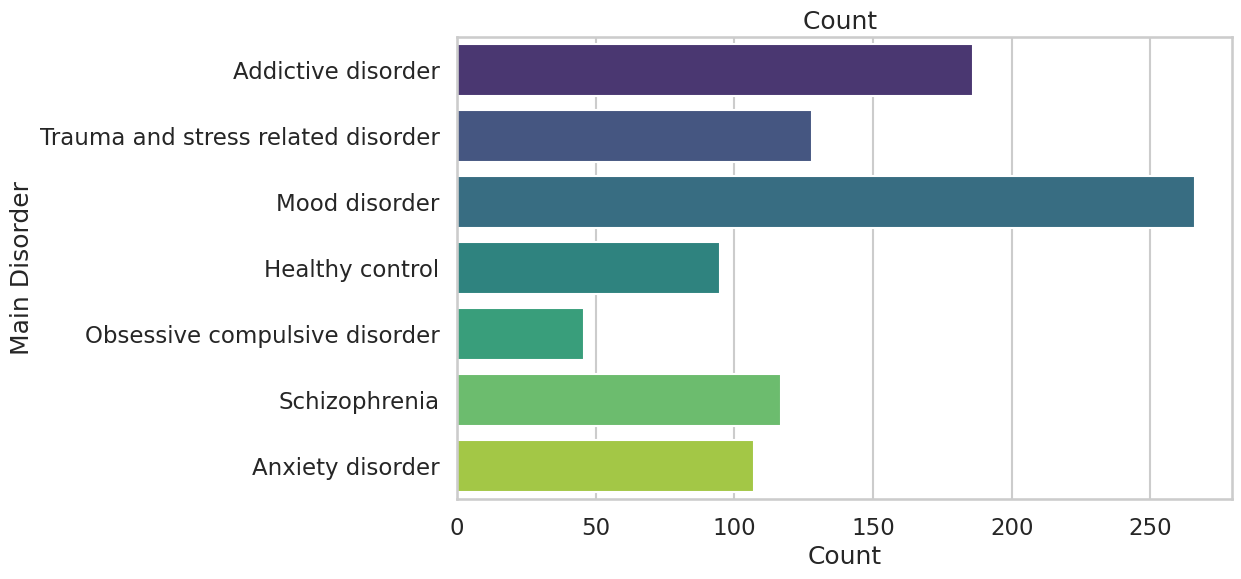

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

# Assuming patients_info is the DataFrame containing the data
countplot = partial(sns.countplot, data=patients_info)

# Set the style and context for better visualization
sns.set(style="whitegrid", context="talk")

# Create the count plot
plt.figure(figsize=(10, 6))
countplot(y='main.disorder', palette="viridis")
plt.title('Count ')
plt.xlabel('Count')
plt.ylabel('Main Disorder')
plt.show()


### Diagnosis

Do we have class disbalance?

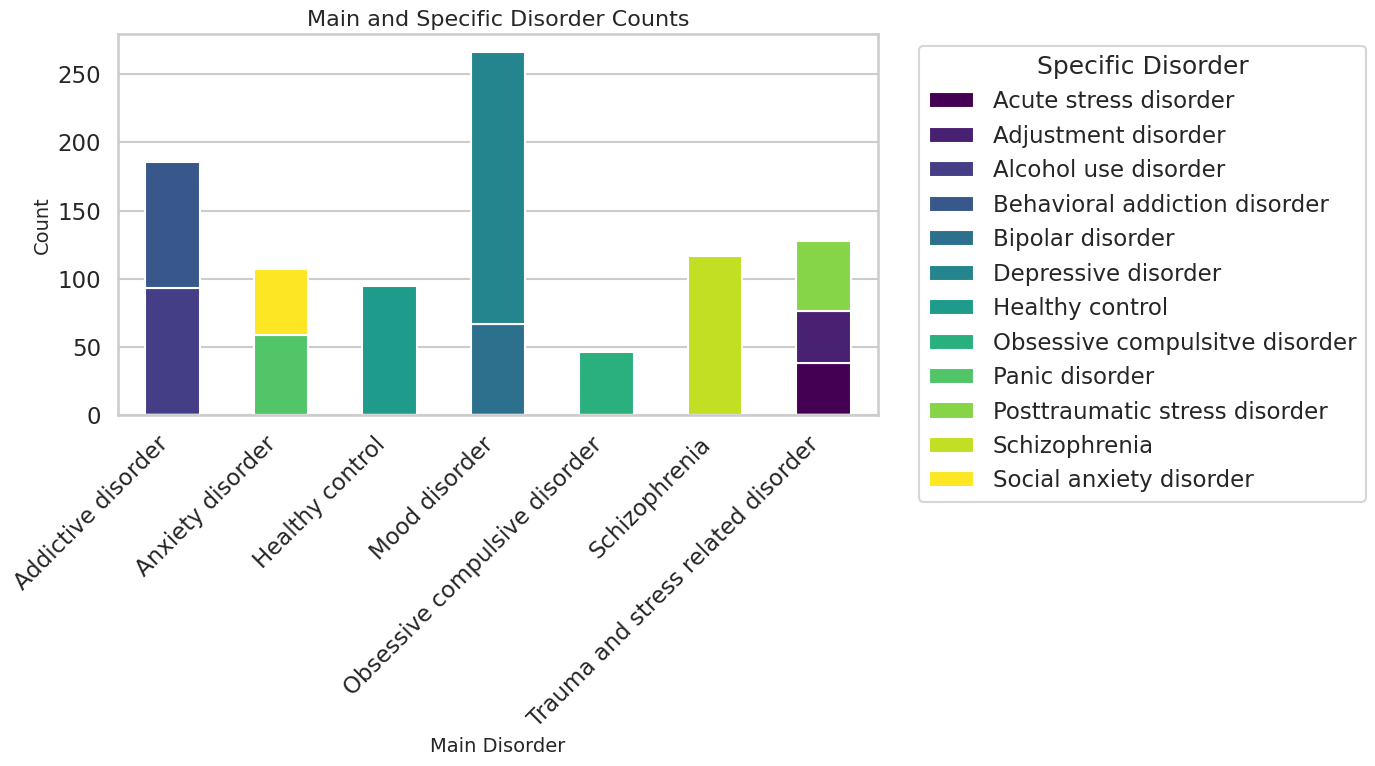

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data for illustration (replace df with your actual DataFrame)
# disorder_counts = df.groupby(['main.disorder', 'specific.disorder']).size()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Sort and unstack the disorder counts
disorder_counts = df.groupby(['main.disorder', 'specific.disorder']).size()
sorted_disorder_counts = disorder_counts.sort_values()
unstacked_counts = sorted_disorder_counts.unstack('specific.disorder')

# Plot the stacked bar chart with improved aesthetics
unstacked_counts.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

# Customize the plot
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left", title="Specific Disorder")
ax.set_title('Main and Specific Disorder Counts', fontsize=16)
ax.set_xlabel('Main Disorder', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.xaxis.grid(False)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Adjust x-tick labels for even distribution
ax.set_xticks(range(len(unstacked_counts.index)))
ax.set_xticklabels(unstacked_counts.index, rotation=45, ha='right')

# Show the plot
plt.show()


Indeed, we do see class disbalances. The most noticeable are:
- Obsessive compulsive disorder
- Specific disorders in Trauma and stress related disorders and Anxiety disorders categories
- Depressive disorder

### Sex
How many male and female subject are present in the dataset?

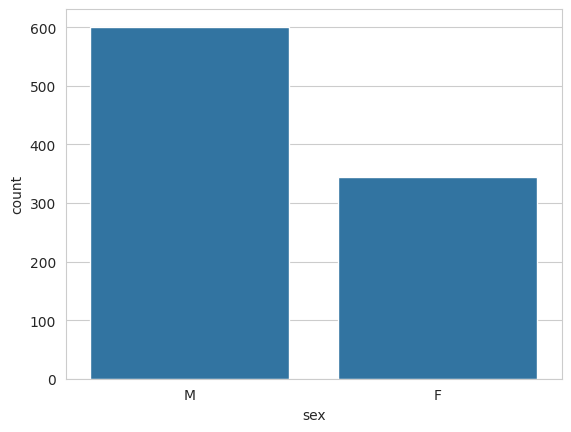

In [ ]:
countplot(x='sex')
plt.show()
countplots(x='sex', col='main.disorder', col_wrap=3)
plt.show()

What is this picture for every diagnosis (main and specific)?

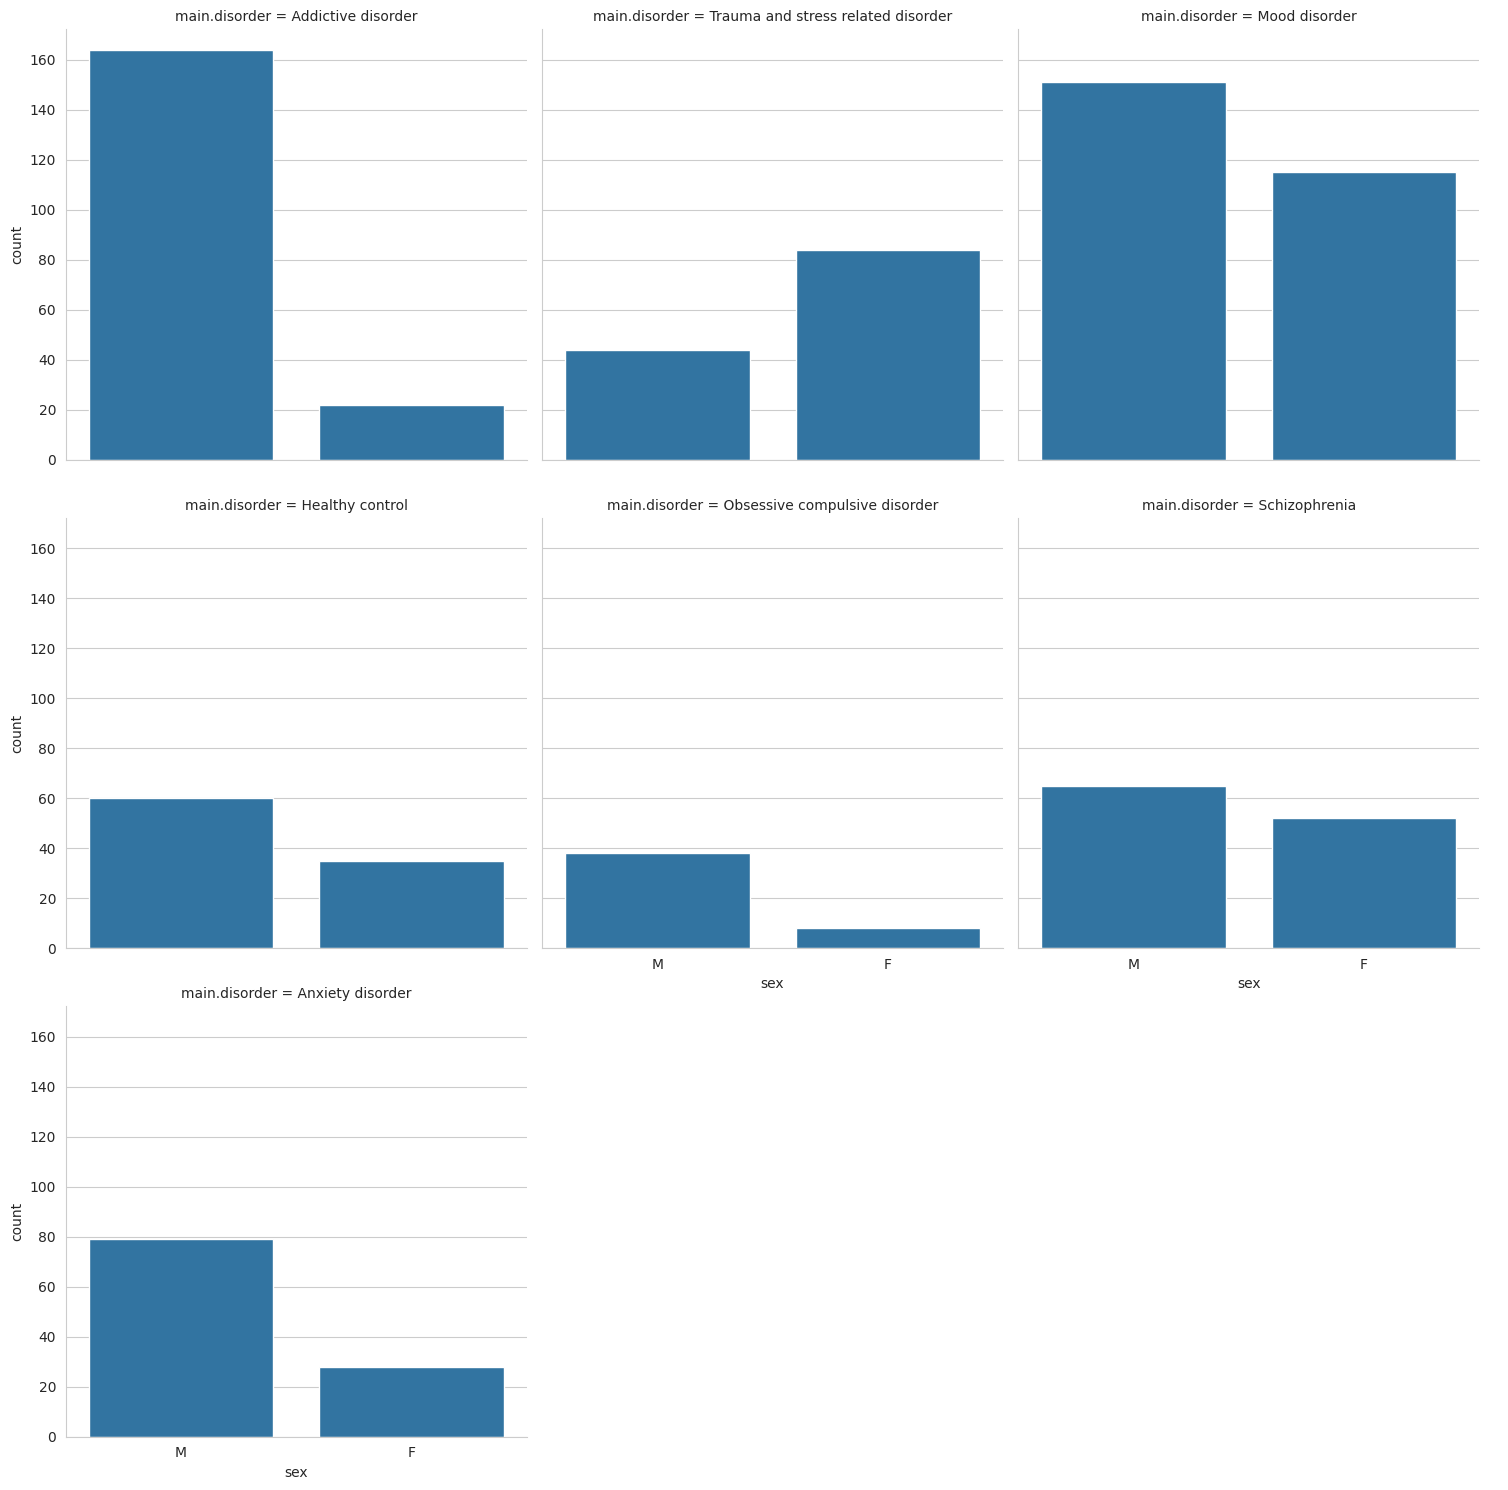

In [ ]:
countplots(x='sex', col='main.disorder', col_wrap=3)
plt.show()

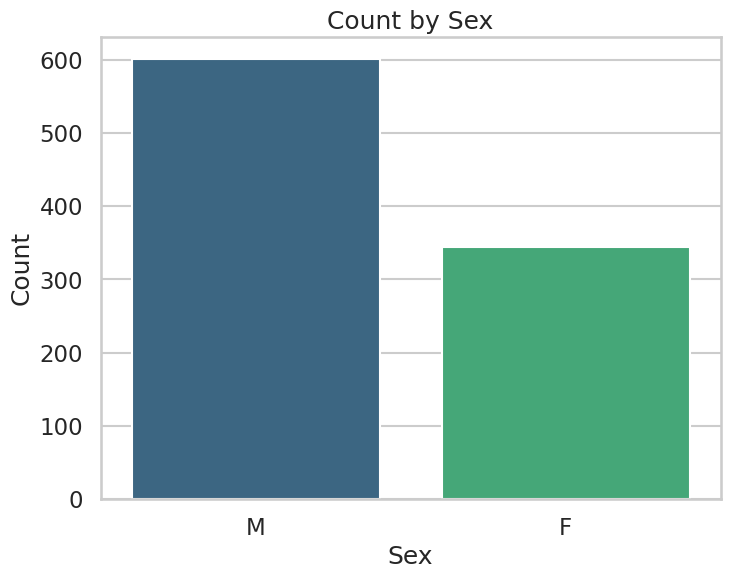

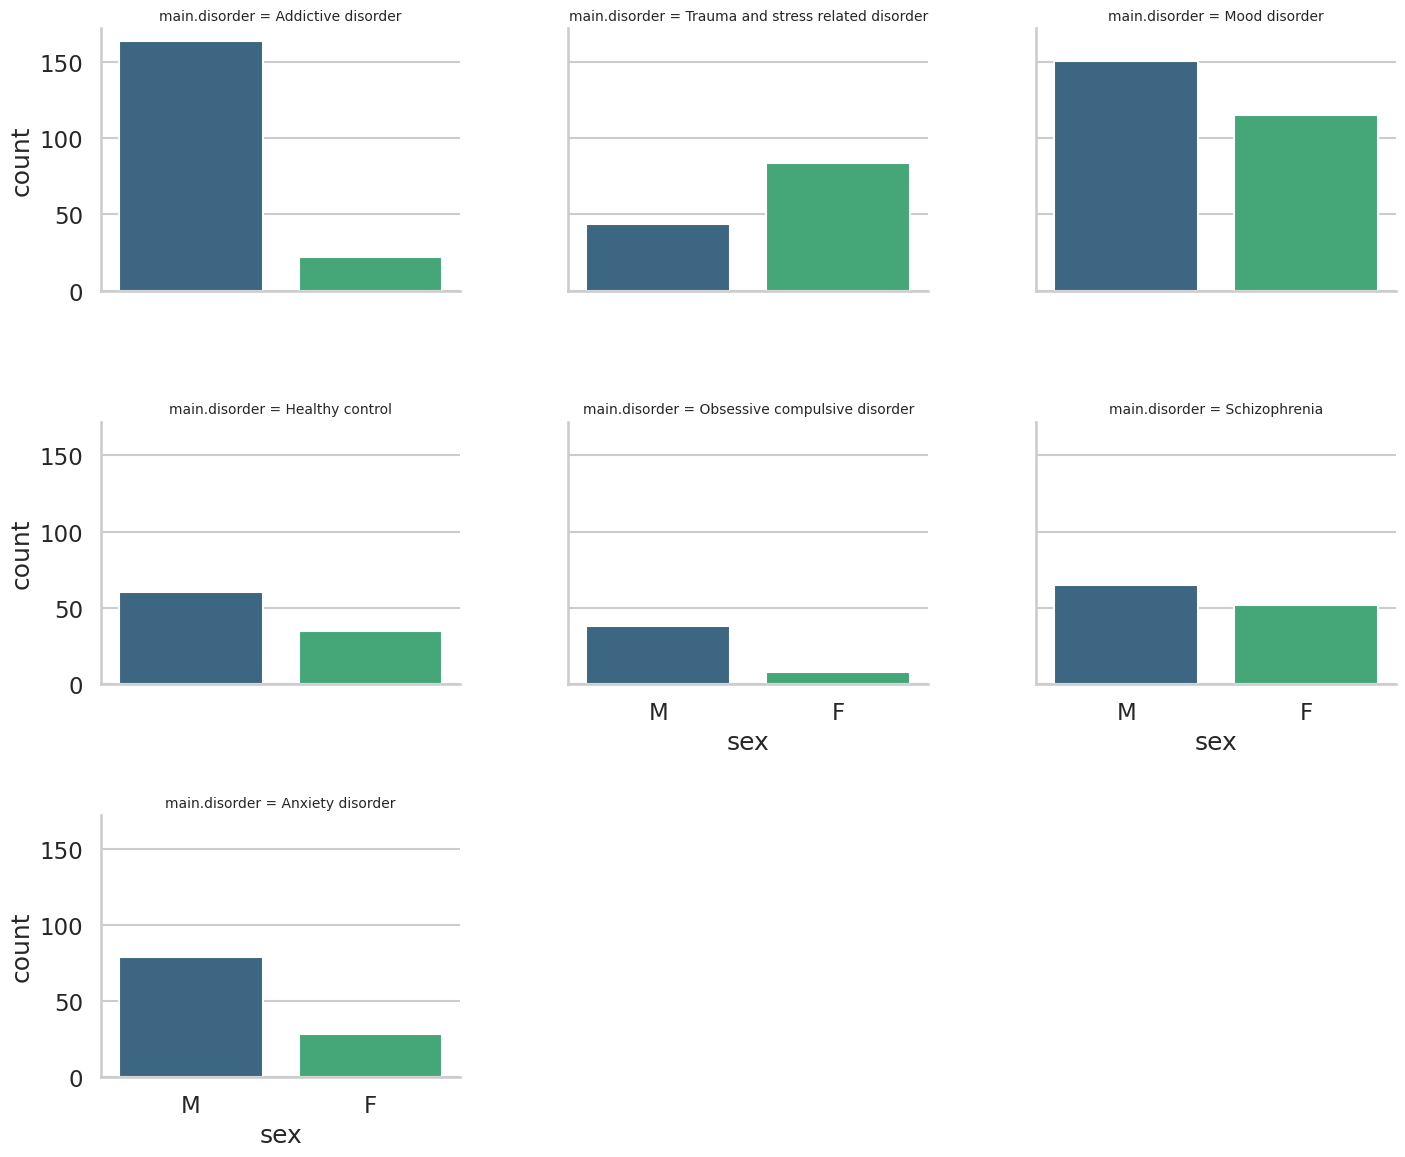

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

# Assuming patients_info is the DataFrame containing the data
countplot = partial(sns.countplot, data=patients_info)
countplots = partial(sns.catplot, data=patients_info, kind='count', col_wrap=3)

# Set the style and context for better visualization
sns.set(style="whitegrid", context="talk")

# Count plot for sex
plt.figure(figsize=(8, 6))
countplot(x='sex', palette="viridis")
plt.title('Count by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

# Count plots for sex by main disorder with increased space between graphs and adjusted titles
g = countplots(x='sex', col='main.disorder', palette="viridis", height=4, aspect=1.2)
g.fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Increase space between graphs

# Adjust titles
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=10)

plt.show()


## Numeric variables

In [ ]:
import pandas as pd
import seaborn as sns
from functools import partial

# Transform the dataframe from wide to long format for better visualization
df_long = patients_info.melt(
    id_vars=['sex', 'main.disorder', 'specific.disorder'],
    value_vars=['age', 'education', 'IQ']
)

# Define a partial function for the first set of distribution plots
displot = partial(
    sns.displot,
    data=df_long,
    kind='hist',
    x='value',
    col='variable',
    col_wrap=3,
    common_bins=False,
    facet_kws={'sharex': False, 'sharey': False}
)

# Define a partial function for the second set of distribution plots
displot2 = partial(
    sns.displot,
    data=patients_info,
    kind='hist',
    col_wrap=3,
    facet_kws={'sharey': False}
)

What distributions numeric does variables have?

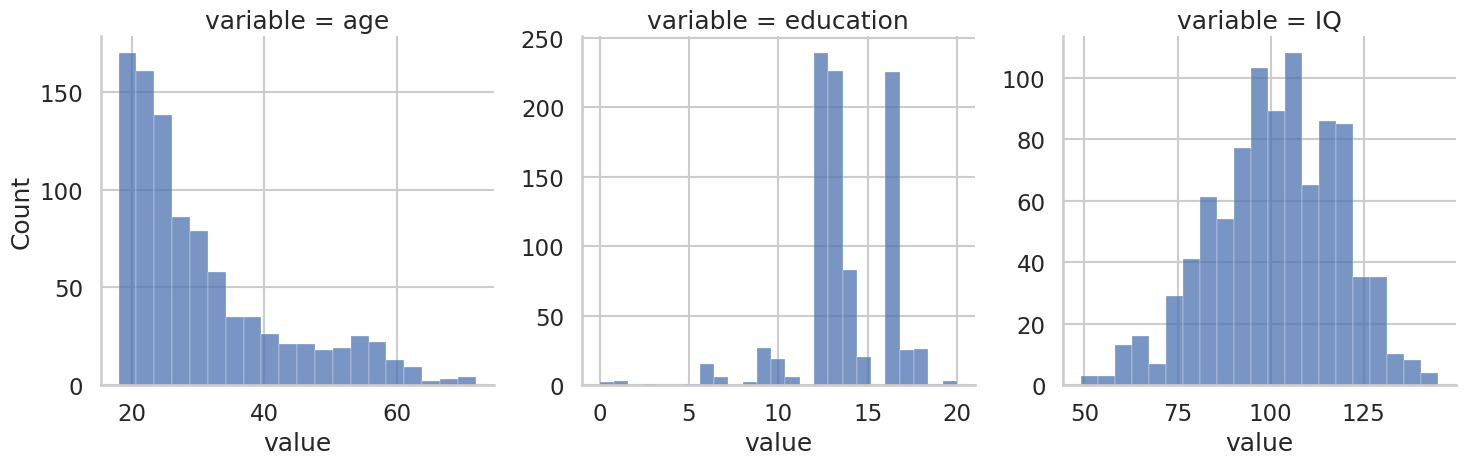

In [ ]:
displot()
plt.show()

Next we want to look into distribution of PSD and FC columns.

### PSD (power spectral density)

KeyboardInterrupt: 

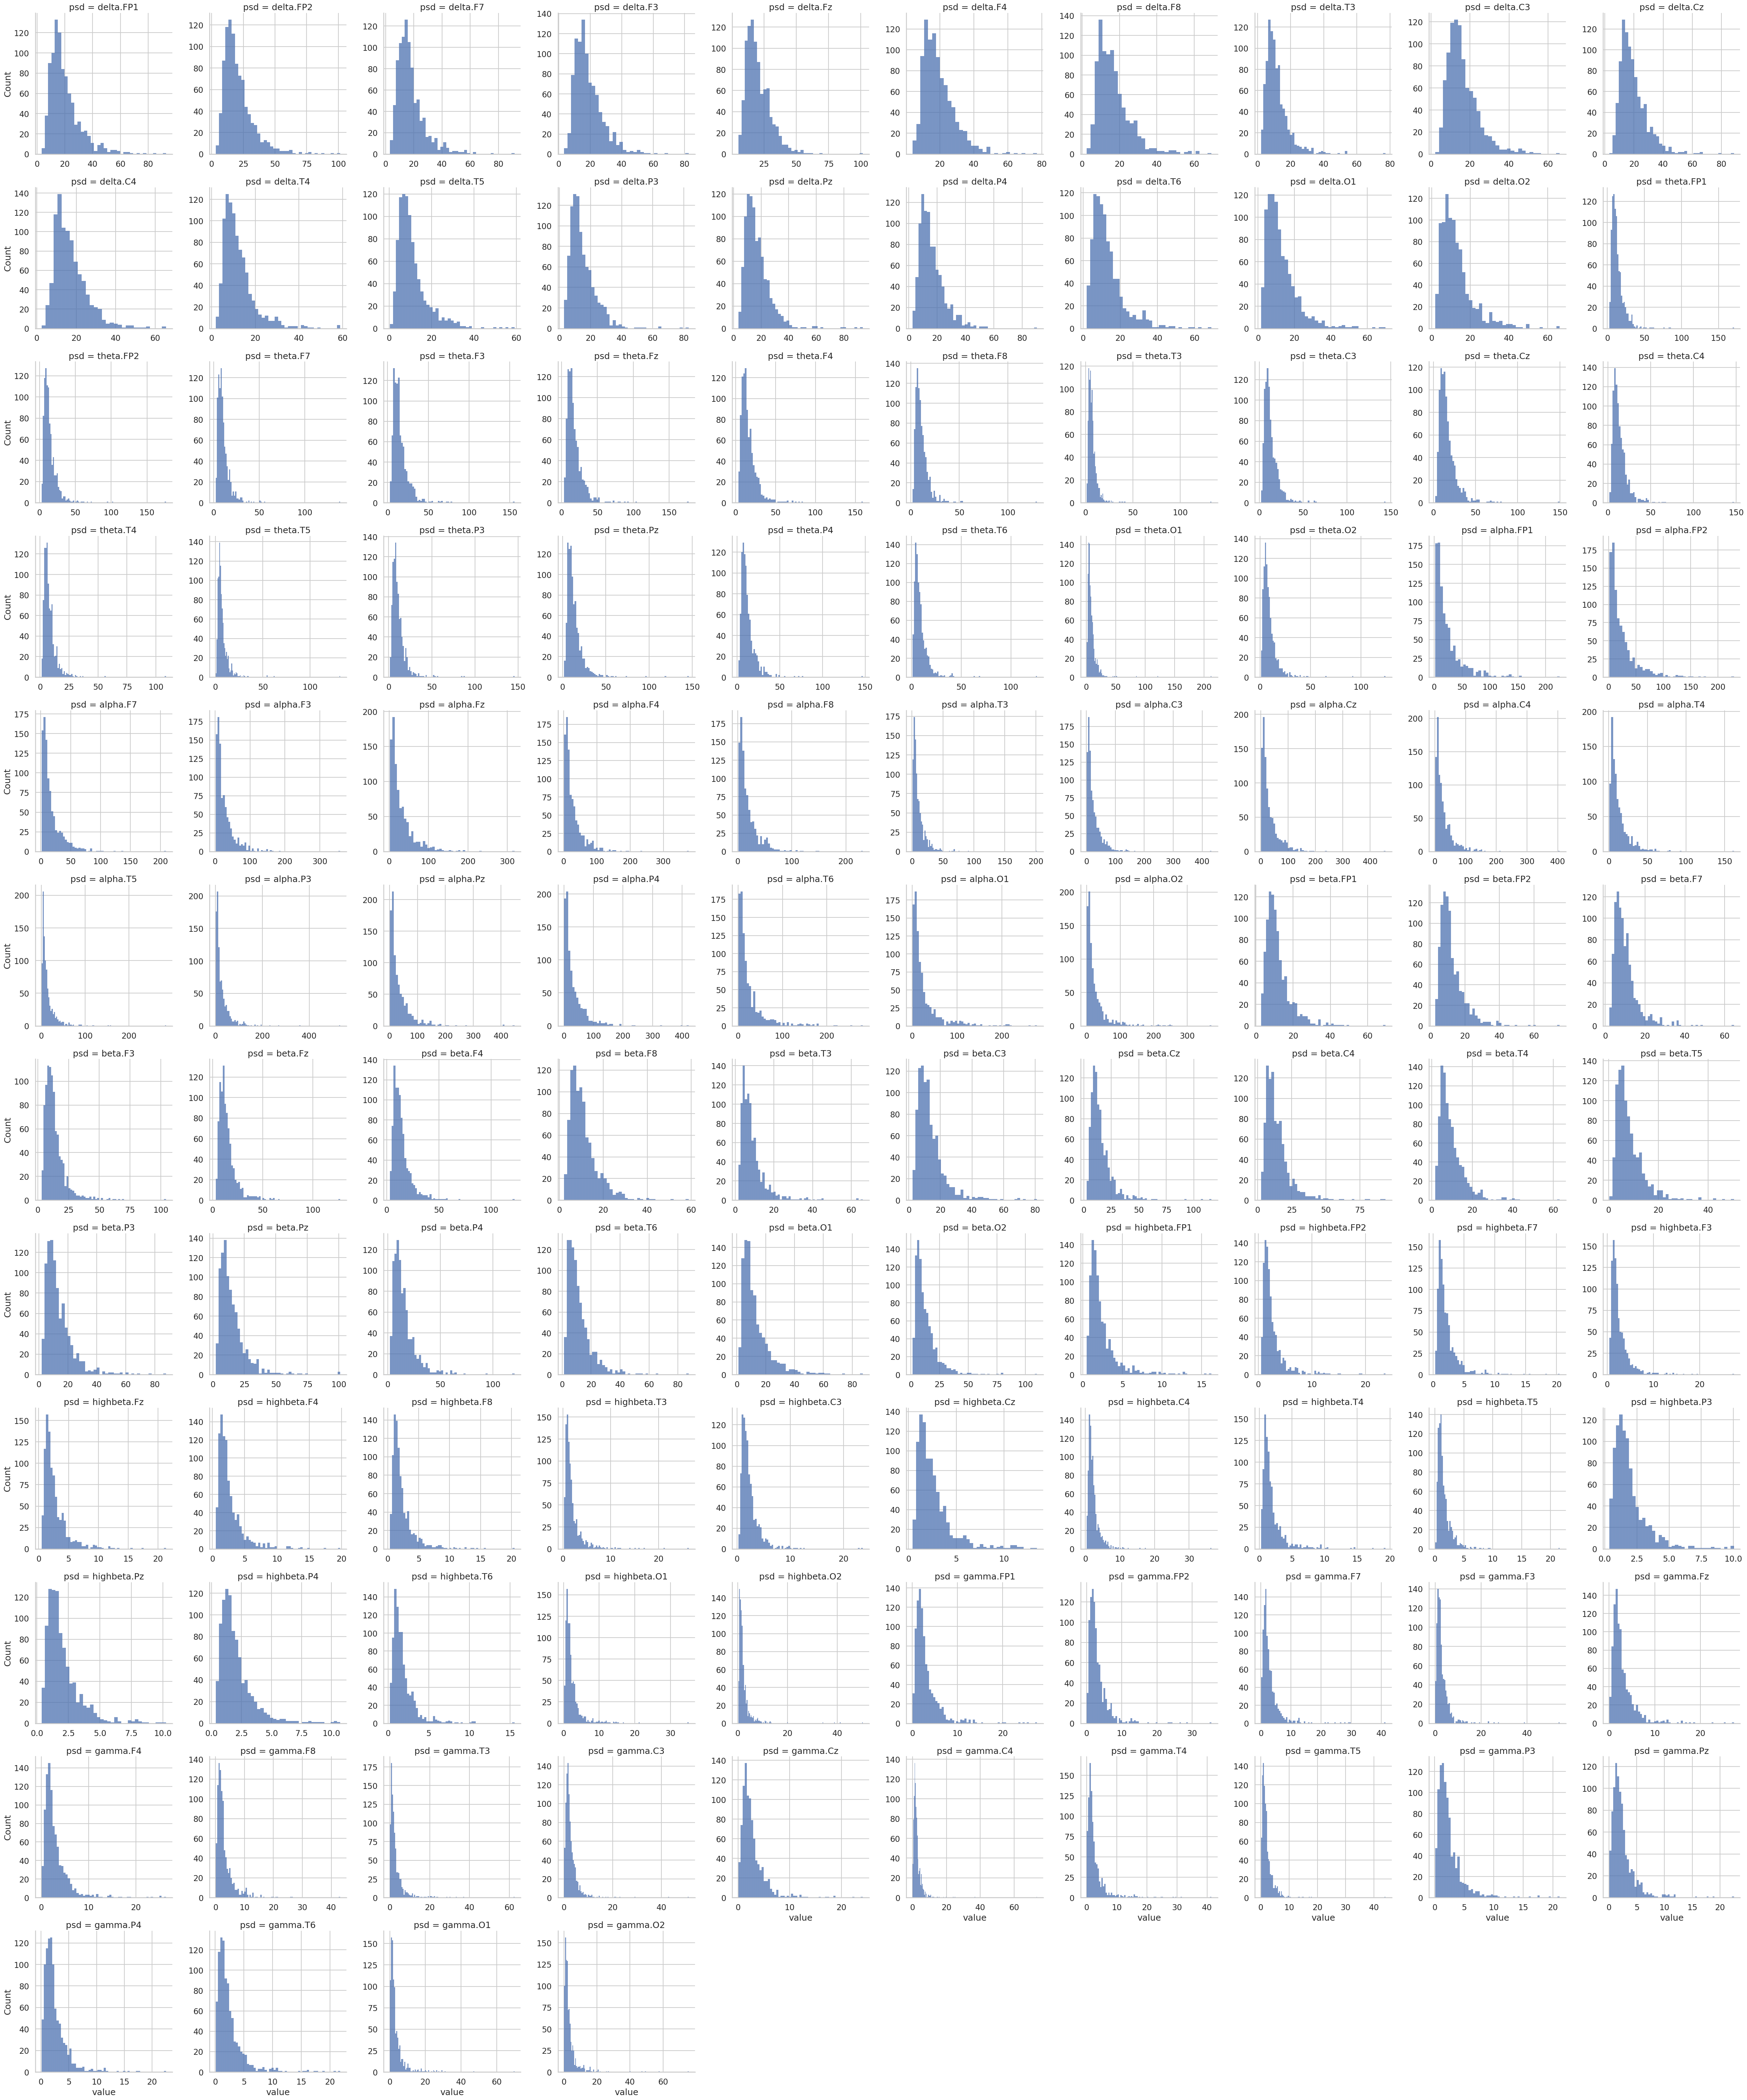

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select columns for power spectral density (PSD) and drop the separating column
psd_cols = df.loc[:, 'delta.FP1':sep_col].drop(sep_col, axis=1).columns

# Create a DataFrame in long format for visualization
psd_long = df.melt(
    id_vars='no.',
    value_vars=psd_cols,
    var_name='psd'
)

# Create distribution plots for each PSD column
sns.displot(
    data=psd_long,
    kind='hist',
    x='value',
    col='psd',
    col_wrap=10,
    common_bins=False,
    facet_kws={'sharey': False, 'sharex': False}
)

# Display the plot
plt.show()

### FC (functional connectivity)

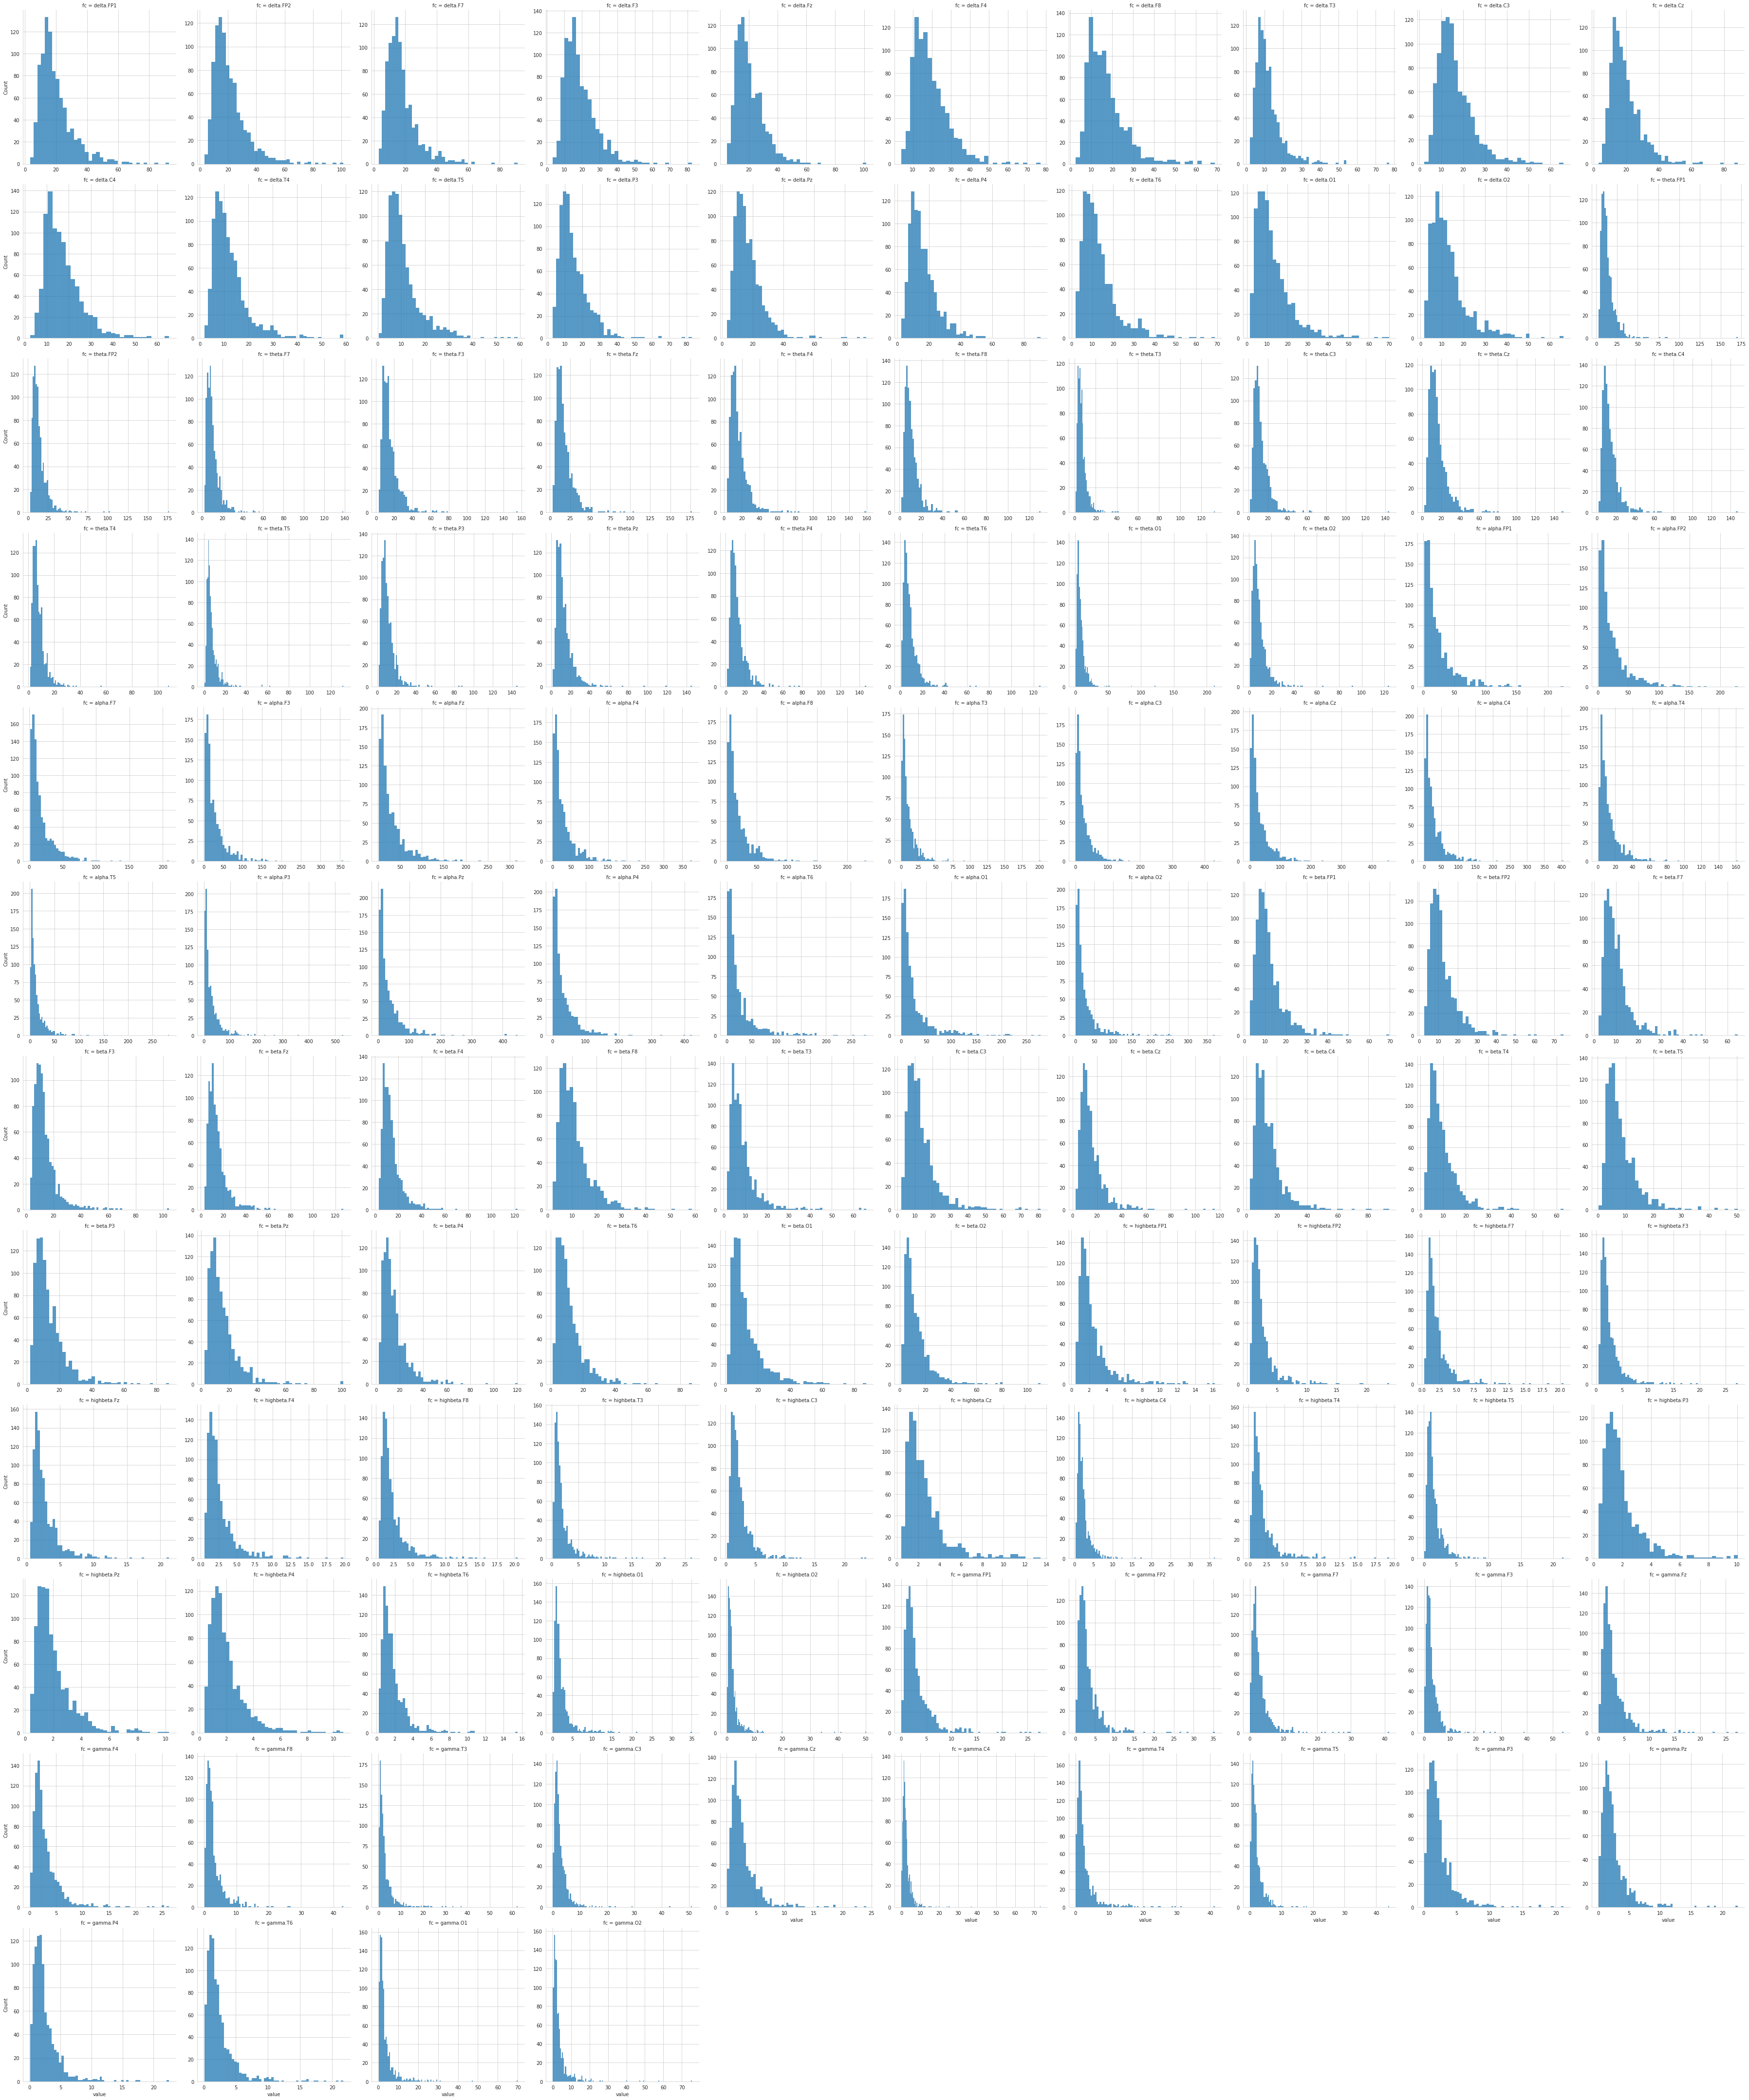

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select columns for functional connectivity (FC) and drop the separating column
fc_cols = df.loc[:, sep_col:'COH.gamma.O1.O2'].drop(sep_col, axis=1).columns

# Create a DataFrame in long format for visualization
fc_long = df.melt(
    id_vars='no.',
    value_vars=fc_cols,
    var_name='fc'
)

# Create distribution plots for each FC column
sns.displot(
    data=fc_long,
    kind='hist',
    x='value',
    col='fc',
    col_wrap=10,
    common_bins=False,
    facet_kws={'sharey': False, 'sharex': False}
)

# Display the plot
plt.show()

### Conclusions

- IQ is normally distributed; no transformation is required.
- The education distribution somewhat resembles a normal distribution, so we will not apply any transformations.
- Age, PSD, and FC features appear to follow a log-normal distribution, so we should consider applying a logarithmic transformation to them.

## Missing data

In [ ]:
missing = df.isna().sum()
missing[missing > 0]

Unnamed: 122    945
dtype: int64

In [ ]:
educ_na = df[df['education'].isna()]
iq_na = df[df['IQ'].isna()]
educ_iq_na = pd.concat([educ_na, iq_na]).drop_duplicates()
educ_iq_na

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,delta.FP1,delta.FP2,...,COH.gamma.Pz.P4,COH.gamma.Pz.T6,COH.gamma.Pz.O1,COH.gamma.Pz.O2,COH.gamma.P4.T6,COH.gamma.P4.O1,COH.gamma.P4.O2,COH.gamma.T6.O1,COH.gamma.T6.O2,COH.gamma.O1.O2


What percentage of data will we lose if we drop rows with missing data (in terms of each main.disorder group)?

In [ ]:
drop_md = educ_iq_na['main.disorder'].value_counts().sort_index()
all_md = df['main.disorder'].value_counts().sort_index()[drop_md.index]
pd.concat([all_md, drop_md/all_md * 100], axis=1).set_axis(['all_data', 'na_percentage'], axis=1).sort_values('na_percentage', ascending=False)

,all_data,na_percentage
main.disorder,,


We loose too much data (13%) on patients with obsessive compulsive disorder, which is one of the smallest groups already. We should consider filling missing data.  
Our options to fill them are:
- special value
- mean/median value
- imputation

Let's fill values with median value

In [ ]:
educ_iq_medians = df[['education', 'IQ']].agg(np.nanmedian)
df[['education', 'IQ']] = df[['education', 'IQ']].fillna(educ_iq_medians)
missing = df.isna().sum()
missing[missing>0]

Unnamed: 122    945
dtype: int64

In [ ]:
df.to_csv('dataset.csv', index=False)

# Visualisation of PSD

In [ ]:
# Define electrode positions
chs = {'FP1': [-0.03, 0.08],
       'FP2': [0.03, 0.08],
       'F7': [-0.073, 0.047],
       'F3': [-0.04, 0.041],
       'Fz': [0, 0.038],
       'F4': [0.04, 0.041],
       'F8': [0.073, 0.047],
       'T3': [-0.085, 0],
       'C3': [-0.045, 0],
       'Cz': [0, 0],
       'C4': [0.045, 0],
       'T4': [0.085, 0],
       'T5': [-0.073, -0.047],
       'P3': [-0.04, -0.041],
       'Pz': [0, -0.038],
       'P4': [0.04, -0.041],
       'T6': [0.07, -0.047],
       'O1': [-0.03, -0.08],
       'O2': [0.03, -0.08]}

channels = pd.DataFrame(chs).transpose()

In [ ]:
def plot_eeg(levels, positions, fig, ch_names=None, cmap='Spectral_r',
             marker=None, marker_style=None, vmin=None, vmax=None, **kwargs):
    """
    Function visulises processed EEG data in a simple way. Based on mne.viz.plot_topomap.


    :param levels: numpy.array, shape (n_chan,)
        data values to plot.
    :param positions: numpy.array, shape (n_chan, 2)|instance of mne.Info
        Location information for the data points(/channels). If an array, for each data point,
        the x and y coordinates. If an Info object, it must contain only one data type and exactly
        len(data) data channels, and the x/y coordinates will be inferred from the montage applied
        to the Info object.
    :param fig: matplotlib.figure.Figure
        The figure to create colorbar on.
    :param ch_names: list | None
        List of channel names. If None, channel names are not plotted.
    :param cmap: matplotlib colormap | None
        Colormap to use. If None, ‘Reds’ is used for all positive data, otherwise defaults to ‘RdBu_r’.
        Default value is 'Spectral_r'
    :param marker: numpy.array of bool, shape (n_channels,) | None
        Array indicating channel(s) to highlight with a distinct plotting style.
        Array elements set to True will be plotted with the parameters given in mask_params.
        Defaults to None, equivalent to an array of all False elements.
    :param marker_style: dict | None
        Additional plotting parameters for plotting significant sensors. Default (None) equals:
        dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=4)
    :param vmin, vmax: float | callable() | None
        Lower and upper bounds of the colormap, in the same units as the data.
        If vmin and vmax are both None, they are set at ± the maximum absolute value
        of the data (yielding a colormap with midpoint at 0). If only one of vmin, vmax is None,
        will use min(data) or max(data), respectively. If callable, should accept a NumPy array
        of data and return a float.
    :param kwargs:
        any other parameter used in mne.viz.plot_topomap
    :return axes: matplotlib.axes.Axes
        axes of the figure
    """
    if 'mask' not in kwargs:
        mask = np.ones(levels.shape[0], dtype='bool')
    else:
        mask = None
    axes = fig.subplots(1, 2, gridspec_kw={'width_ratios': [12, 1]})
    im, cm = mne.viz.plot_topomap(levels, positions, axes=axes[0], names=ch_names, vlim=(vmin, vmax),
                          cmap=cmap, mask=mask, mask_params=marker_style, show=False, **kwargs)
    #axes[1].set_position([cb_pos[0], cb_pos[1], cb_width, cb_height])
    clb = fig.colorbar(im, cax=axes[1])
    return axes

def plot_eeg_dataset(dataset, channels, gwidth=2, gheight=1.5, wspace=0, char_space=2,
                     marker_style={'markersize': 2, 'markerfacecolor': 'black'},
                     band_ordered=None, conditions_ordered=None, band_labels=None,
                     condition_labels=None, **kwargs):
    """
    Visualisation of pre-processed EEG dataset.
    See example of usage on Kaggle (https://www.kaggle.com/code/lazygene/visualising-pre-processed-eeg-data)
    :param dataset: pandas.DataFrame
        Data set to visualise. See format of the dataset on Kaggle (url above).
    :param channels: pandas.DataFrame
        Channel (index) names and positions (columns: x and y).
    :param gwidth: float
        Width of single topology map.
    :param gheight: float
        Height of single topology map.
    :param wspace: float
        Space between subplots
    :param marker_style:
        marker_style: dict
        Additional plotting parameters for plotting significant sensors. Default (None) equals:
        dict(marker='o', markerfacecolor='black', markeredgecolor='k', linewidth=0, markersize=2)
    :param band_ordered: list | None
        List of EEG bands (e.g. delta, gamma, etc.), they must be one or more columns of dataset DataFrame.
        Provides a way to control the order (form top to bottom) of bands in the resulted complex figure.
        If None, all columns of dataset are used in orfer of columns.
    :param conditions_ordered: list | None
        List of conditions, they must be one or more level 0 indecies of dataset DataFrame.
        Provides a way to control the order (from left to right) of conditions in the resulted complex figure.
        If None, all unique 0 level indecies of dataset are used in order they are in the dataset.
    :param band_labels: list | None
        List of custom labels for EEG bands, it must be the same length as band_ordered.
        If None, column names of dataset DataFrame are used.
    :param condition_labels:
        List of custom labels for conditions, it must be the same length as conditions_ordered.
        If None, original indecies' names of dataset DataFrame are used.
    :param kwargs:
        any other parameter used in plot_eeg
    :return: fig: matplotlib.figure.Figure
    :return: subfigs: np.array of matplotlib.figure.Figure elements
    """
    if band_ordered is None:
        band_ordered = dataset.columns
    if conditions_ordered is None:
        conditions_ordered = dataset.index.get_level_values(0).unique()
    if band_labels is None:
        band_labels = band_ordered
    if condition_labels is None:
        condition_labels = conditions_ordered
    # number of rows in figure
    nrows = len(band_ordered)
    # number of columns in figure
    ncols = len(conditions_ordered)
    # create figure with width gwidth and gheight per graph
    fig = plt.figure(constrained_layout=True, figsize=(gwidth*ncols, gheight*nrows))
    # create subfigures
    subfigs = fig.subfigures(nrows, ncols, wspace=wspace)
    # determine the absolute max
    absmax = ceil(dataset.max().max())
    # length of label in # of characters
    len_lab = len(str(absmax))
    # loop through subfigures
    for ind, subfig in np.ndenumerate(subfigs):
        i, j = ind
        # select band (column name in main_mean)
        band = band_ordered[i]
        # select disorder (row name in main_mean)
        disorder = conditions_ordered[j]
        # select band levels for disorder
        levels = dataset.loc[disorder, band]
        # calculate maximum (vmax) for easier comparison between disorders
        vmax = ceil(max(dataset[band]))
        # plot eeg
        ax =  plot_eeg(levels, channels.to_numpy(), subfig, vmin=0, vmax=vmax, marker_style=marker_style, **kwargs)
        # adjust labels
        lendiff = len_lab - len(str(vmax))
        if lendiff != 0:
            ticks = ax[1].get_yticks()
            labs = [str(round(x)).ljust(len_lab+lendiff*(char_space-1), ' ') for x in ticks]
            ax[1].yaxis.set_major_locator(mticker.FixedLocator(ticks))
            ax[1].set_yticklabels(labs)
        # annotate band (if needed)
        if j == 0:
            ax[0].set_ylabel(band_labels[i])
        else:
            ax[0].set_ylabel(" ")
        if i == 0:
            subfig.suptitle(condition_labels[j], y=1.3)
    return fig, subfigs

In [ ]:
# One of the columns contains no data, it separates data
# patient info | abs power of PSD per band per channel | sep_col | functional connectivity data
mis = df.isna().sum()
sep_col = mis[mis == df.shape[0]].index[0]
qeeg = df.loc[:, 'main.disorder':sep_col].drop(sep_col, axis=1)

In [ ]:
qeeg.groupby('main.disorder').mean()

TypeError: Could not convert Alcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderBehavioral addiction disorderAlcohol use disorderAlcohol use disorderBehavioral addiction disorderBehavioral addiction disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderBehavioral addiction disorderBehavioral addiction disorderBehavioral addiction disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderBehavioral addiction disorderAlcohol use disorderBehavioral addiction disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderAlcohol use disorderBehavioral addiction disorderBehavioral addiction disorderAlcohol use disorder to numeric

In [ ]:
# mean powers per main disorder

# # qeeg = qeeg[qeeg['main.disorder'].str.isnumeric()]
# qeeg['main.disorder'] = pd.to_numeric(qeeg['main.disorder'])
# qeeg['main.disorder'] = pd.to_numeric(qeeg['main.disorder'])
qeeg['specific.disorder'] = pd.to_numeric(qeeg['specific.disorder'])
main_mean = qeeg.groupby('main.disorder').mean().reset_index()
# mean powers per main disorder
spec_mean = qeeg.groupby('specific.disorder').mean().reset_index()
# list of bands
bands = ['delta', 'theta', 'alpha', 'beta', 'highbeta', 'gamma']
# convert from wide to long
main_mean = pd.wide_to_long(main_mean, bands, ['main.disorder'], 'channel', sep='.', suffix='\w+')
spec_mean = pd.wide_to_long(spec_mean, bands, ['specific.disorder'], 'channel', sep='.', suffix='\w+')

ValueError: Unable to parse string "Alcohol use disorder" at position 0

## Main disorders

In [ ]:
matplotlib.style.use('default')
# order conditions (main.disorder)
conds = ['Healthy control',
         'Schizophrenia',
         'Mood disorder',
         'Anxiety disorder',
         'Obsessive compulsive disorder',
         'Addictive disorder',
         'Trauma and stress related disorder']
conds_labs = [x.replace('disorder', '') for x in conds]
plot_eeg_dataset(main_mean, channels, conditions_ordered=conds, condition_labels=conds_labs)
plt.show()

ValueError: cannot convert float NaN to integer

<Figure size 1400x1050 with 0 Axes>

## Specific disorders

In [ ]:
conds = ['Healthy control',
         'Depressive disorder',
         'Bipolar disorder',
         'Panic disorder',
         'Social anxiety disorder',
         'Alcohol use disorder',
         'Behavioral addiction disorder',
         'Posttraumatic stress disorder',
         'Acute stress disorder',
         'Adjustment disorder']
conds_labs = [x.replace('disorder', '') for x in conds]
plot_eeg_dataset(spec_mean, channels, conditions_ordered=conds, condition_labels=conds_labs)
plt.show()

ValueError: cannot convert float NaN to integer

<Figure size 2000x1050 with 0 Axes>

As we can see, there are differences in avereged QEEG PSD between people with different desorders.

# Multiclass classification
## Pre-processing
1. Drop unique columns (separation column, no. and eeg.date)
1. Encode categorical variable sex and targets (main.disorder and specific.disorder)
1. Save targets and drop them from feature set
1. Perform logarithmic transformation of numeric columns, except education and IQ)
1. Split data into train and test subset
1. Scale train and test data

In [ ]:
# Prepare for encoding
cat_vars = ['sex', 'main.disorder','specific.disorder']
targets = ['main.disorder', 'specific.disorder']
# Drop unique columns
X = df.drop([sep_col, 'no.', 'eeg.date'], axis=1).copy(deep=True)
# columns for log transformation
logtrans_cols = X.drop(['sex', 'education', 'IQ']+targets, axis=1).columns
# Encode categorical variables (target columns and sex)
enc = OrdinalEncoder()
X[cat_vars] = enc.fit_transform(X[cat_vars])
# Save targets
md_target = X['main.disorder']
sd_target = X['specific.disorder']
# Drop targets
X.drop(['main.disorder', 'specific.disorder'], axis=1, inplace=True)
# Perform logarithmic transformation on all data except sex, education and IQ
logtrans_cols = X.drop(['sex', 'education', 'IQ'], axis=1).columns
X[logtrans_cols] = np.log(X[logtrans_cols])
# save features' names
feature_names = X.columns
# main.disorder
Xmd_train, Xmd_test, Ymd_train, Ymd_test = train_test_split(X, md_target, test_size=0.33, random_state=77)
# specific.disorder
Xsd_train, Xsd_test, Ysd_train, Ysd_test = train_test_split(X, sd_target, test_size=0.33, random_state=77)
# Scale features
# main.disorder
md_scaler = StandardScaler()
Xmd_train = md_scaler.fit_transform(Xmd_train)
Xmd_test = md_scaler.transform(Xmd_test)
# specific.disorder
sd_scaler = StandardScaler()
Xsd_train = sd_scaler.fit_transform(Xsd_train)
Xsd_test = sd_scaler.transform(Xsd_test)

## Cross-validation
Algorithms to consider:
- Logistic Regression, ElasticNet
- SVM, Linear Kernel (to have access to feature importance)
- Random Forest
- XGBoost
- LightGBM
- CatBoost

In [ ]:
def lists_to_dict (keys, items):
    return {key: item for key,item in zip(keys, items)}

# models names
model_names = ['EN', 'SVM', 'RF', 'XGB', 'LGBM', 'CatBoost']
# param grids for gridsearch
param_grids = [
    {
        'l1_ratio': np.linspace(0, 1, 5),
        'C': [0.5, 1, 5, 10]
    },
    {
        'C': [0.5, 1, 5, 10]
    },
    {
        'n_estimators': [100, 300, 500],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'subsample': [0.3, 0.5, 1],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'subsample': [0.3, 0.5, 1],
        'max_depth': [1, 3, 6, None]
    },
    {
        'n_estimators': [100, 300, 500],
        'max_depth': [1, 3, 6, None],

    }
]
param_grids = lists_to_dict(model_names, param_grids)

# models for gridsearch
models = [
    LogisticRegression(penalty='elasticnet', solver='saga'),
    SVC(random_state=77, probability=True),
    RandomForestClassifier(random_state=77),
    XGBClassifier(tree_method='gpu_hist'),
    LGBMClassifier(random_state=77, device='gpu'),
    CatBoostClassifier(random_seed=77,logging_level='Silent', task_type='GPU')
]
models = lists_to_dict(model_names, models)

In [ ]:
def n_best (gs_res, n=1):
    """Returns nth best estimator parameters, mean score and std of it"""
    ind = np.where(gs_res['rank_test_score'] == n)[0][0]
    mu = gs_res["mean_test_score"][ind]
    std = gs_res["std_test_score"][ind]
    params = gs_res["params"][ind]
    return params, mu, std

def cache_mkdir(cache, directory, root_dir='.'):
    directory = directory.replace(' ', '_')
    path = os.path.join(root_dir, directory)
    if cache and not os.path.exists(path):
        os.makedirs(path)
    return path

def read_cache(cache, path, silent=False):
    result = None
    if cache and os.path.exists(path):
        with open(path, 'rb') as file:
            if not silent:
                print(f'Extracted from cache ({path})')
            result = pickle.load(file)
    return result

def write_cache(cache, obj, path):
    if cache:
        with open(path, 'wb') as file:
            pickle.dump(obj, file)

def grid_search(models, params, X, Y, random_seed=None, cache=True, cache_dir='grid_search', silent=False, **kwargs):
    # result dict
    result = []
    # create cache directory if needed
    root_dir = cache_mkdir(cache, cache_dir)
    for key in models.keys():
        print(key)
        # get cache file path
        cache_file = os.path.join(root_dir, key)
       # read file from cache
        res = read_cache(cache, cache_file, silent)
        if res is None:
            res = {}
            res['algorithm'] = key
            # set seed
            if random_seed is not None:
                np.random.seed(random_seed)
            # scale
            scaler = StandardScaler()
            x = scaler.fit_transform(X)
            # gridsearch
            gs = GridSearchCV(models[key], params[key], cv=10, scoring='roc_auc_ovr', n_jobs=-1, verbose=1, **kwargs).fit(x, Y)
            # best estimator parameters, cross validation mean score and score std
            res['params'], res['mean_score'], res['std_score'] = n_best(gs.cv_results_)
            # save cv_results_
            res['cv_result'] = deepcopy(gs.cv_results_)
            # cache results
            write_cache(cache, res, cache_file)
        result.append(res)
    return result

### Main disorder

In [ ]:
import warnings
warnings.filterwarnings('ignore')
md_res_dict = grid_search(models, param_grids, Xmd_train, Ymd_train, random_seed=77, cache_dir='grid_search/main')
md_results = pd.DataFrame(md_res_dict)
md_results

EN
Fitting 10 folds for each of 20 candidates, totalling 200 fits
SVM
Fitting 10 folds for each of 4 candidates, totalling 40 fits
RF
Fitting 10 folds for each of 12 candidates, totalling 120 fits
XGB
Fitting 10 folds for each of 36 candidates, totalling 360 fits


ValueError: 
All the 360 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:10] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:10] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:10] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:10] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:11] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:11] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:11] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:11] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:12] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:12] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:12] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:12] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:13] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:13] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:13] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:13] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:14] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:14] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:14] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:14] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:15] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:15] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:15] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:15] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:16] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:16] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:16] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:16] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:17] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:17] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:17] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:17] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:18] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:18] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:18] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:18] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:19] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:19] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:19] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:19] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:20] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:20] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:20] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:20] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:21] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:21] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:21] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:21] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:22] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:22] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:22] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:22] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:23] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:23] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:23] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:23] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:24] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:24] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:24] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:24] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:25] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:25] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:25] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:25] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:26] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:26] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:26] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:26] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:27] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:27] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:27] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:27] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:28] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:28] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:28] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:28] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:29] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:29] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:29] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:29] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:30] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:30] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:30] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:30] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:31] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:31] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:31] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:31] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:32] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:32] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:32] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:32] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:33] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:33] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:33] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:33] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:34] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:34] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:34] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:34] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:35] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:35] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:35] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:35] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:36] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:36] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:36] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:36] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:37] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:37] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:37] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:37] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:38] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:38] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:38] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:38] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:39] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:39] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:39] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:39] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:40] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:40] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:40] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:40] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:41] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:41] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:41] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:41] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:42] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:42] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:42] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:42] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:43] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:43] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:43] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:43] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:44] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:44] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:44] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:44] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:45] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:45] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:45] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:45] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:46] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:46] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:46] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:46] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:47] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:47] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:47] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:47] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:48] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:48] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:48] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:48] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:49] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:49] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:49] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:49] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:50] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:50] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:50] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:50] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:51] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:51] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:51] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:51] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:52] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:52] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:52] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:52] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:53] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:53] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:53] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:53] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:54] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:54] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:54] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:54] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:55] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:55] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:55] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:55] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:56] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:56] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:56] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:56] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:57] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:57] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:57] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:57] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:58] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:58] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:58] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:58] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:59] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:59] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:52:59] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:52:59] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:53:00] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:53:00] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:53:00] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:53:00] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:53:01] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:53:01] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:53:01] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:53:01] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:53:02] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:53:02] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:53:02] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:53:02] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:53:03] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:53:03] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:53:03] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:53:03] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:53:04] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:53:04] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]



--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:53:04] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:53:04] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:53:05] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:53:05] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x7f29e1f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x7f29e1f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x7f29e1f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x7f29e1f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x7f29e1882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x7f29e1883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x7f29e18e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x7f29e1583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7f2a10327e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7f2a10324493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x7f2a103373e9]



--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py", line 1519, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/training.py", line 181, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 2050, in update
    _check_call(
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 282, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [20:53:05] /workspace/src/tree/updater_gpu_hist.cu:781: Exception in gpu_hist: [20:53:05] /workspace/src/tree/updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb3e95a) [0x787ad5f6095a]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb483cd) [0x787ad5f6a3cd]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (6) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (8) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]



Stack trace:
  [bt] (0) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb27f2a) [0x787ad5f49f2a]
  [bt] (1) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0xb485c9) [0x787ad5f6a5c9]
  [bt] (2) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x460c79) [0x787ad5882c79]
  [bt] (3) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x461d09) [0x787ad5883d09]
  [bt] (4) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(+0x4c54f7) [0x787ad58e74f7]
  [bt] (5) /usr/local/lib/python3.10/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x70) [0x787ad5583ef0]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x787b034b2e2e]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x787b034af493]
  [bt] (8) /usr/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xa3e9) [0x787b034c23e9]




### Specific disorder

In [ ]:
sd_res_dict = grid_search(models, param_grids, Xsd_train, Ysd_train, random_seed=77, cache_dir='grid_search/specific')
sd_results = pd.DataFrame(sd_res_dict)
sd_results

EN
Extracted from cache (./grid_search/specific/EN)
SVM
Extracted from cache (./grid_search/specific/SVM)
RF
Extracted from cache (./grid_search/specific/RF)
XGB
Extracted from cache (./grid_search/specific/XGB)
LGBM
Extracted from cache (./grid_search/specific/LGBM)
CatBoost
Extracted from cache (./grid_search/specific/CatBoost)


,algorithm,params,mean_score,std_score,cv_result
0,EN,"{'C': 0.5, 'l1_ratio': 1.0}",0.625317,0.044829,"{'mean_fit_time': [7.919480705261231, 21.32514..."
1,SVM,{'C': 1},0.581727,0.040113,"{'mean_fit_time': [3.0026245594024656, 2.81752..."
2,RF,"{'max_depth': 3, 'n_estimators': 100}",0.610953,0.028649,"{'mean_fit_time': [0.37077138423919676, 1.1817..."
3,XGB,"{'max_depth': 1, 'n_estimators': 300, 'subsamp...",0.646413,0.026976,"{'mean_fit_time': [3.2121956586837768, 2.50120..."
4,LGBM,"{'max_depth': None, 'n_estimators': 300, 'subs...",0.642344,0.039271,"{'mean_fit_time': [5.220911645889283, 5.130621..."
5,CatBoost,"{'max_depth': 1, 'n_estimators': 500}",0.646237,0.035930,"{'mean_fit_time': [3.086733341217041, 5.816065..."


## Training

In [ ]:
models

{'EN': LogisticRegression(penalty='elasticnet', solver='saga'),
 'SVM': SVC(probability=True, random_state=77),
 'RF': RandomForestClassifier(random_state=77),
 'XGB': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=None,
               reg_alpha=None, reg_lambda=None, ...),
 'LGBM': LGBMClassifier(device='gpu', random_state=77),
 'CatBoost': <catboost.c

In [ ]:
def train_all(res_tab, Xtrain, Ytrain, model_list=None):
    if model_list is None:
        model_list = res_tab['algorithm'].unique()
    table = res_tab[res_tab['algorithm'].isin(model_list)].set_index('algorithm')
    result = dict()
    for model_name in model_list:
        model = deepcopy(models[model_name])
        model.set_params(**table.loc[model_name, 'params'])
        model.fit(Xtrain, Ytrain)
        result[model_name] = model
    return result


In [ ]:
md_models = train_all(md_results, Xmd_train, Ymd_train)

In [ ]:
sd_models = train_all(sd_results, Xsd_train, Ysd_train)

## Evaluating models

In [ ]:
def eval_all(models, Xtest, Ytest, model_list=None, **kwargs):
    if model_list is None:
        model_list = list(models.keys())
    for key, model in models.items():
        print(key)
        y_pred = model.predict(Xtest)
        print(classification_report(Ytest, y_pred, **kwargs))

### Main disorders

In [ ]:
eval_all(md_models, Xmd_test, Ymd_test, target_names=enc.categories_[1])

EN
                                    precision    recall  f1-score   support

                Addictive disorder       0.40      0.41      0.40        74
                  Anxiety disorder       0.17      0.12      0.14        34
                   Healthy control       0.32      0.33      0.33        24
                     Mood disorder       0.35      0.42      0.38        90
     Obsessive compulsive disorder       0.00      0.00      0.00        23
                     Schizophrenia       0.16      0.24      0.19        29
Trauma and stress related disorder       0.33      0.26      0.29        38

                          accuracy                           0.31       312
                         macro avg       0.25      0.25      0.25       312
                      weighted avg       0.29      0.31      0.30       312

SVM
                                    precision    recall  f1-score   support

                Addictive disorder       0.32      0.30      0.31        74
 

### Specific disorders

In [ ]:
eval_all(sd_models, Xsd_test, Ysd_test, target_names=enc.categories_[2])

EN
                                precision    recall  f1-score   support

         Acute stress disorder       0.25      0.22      0.24         9
           Adjustment disorder       0.14      0.08      0.11        12
          Alcohol use disorder       0.21      0.23      0.22        35
 Behavioral addiction disorder       0.39      0.33      0.36        39
              Bipolar disorder       0.00      0.00      0.00        22
           Depressive disorder       0.30      0.37      0.33        68
               Healthy control       0.32      0.38      0.35        24
Obsessive compulsitve disorder       0.00      0.00      0.00        23
                Panic disorder       0.17      0.10      0.12        21
 Posttraumatic stress disorder       0.00      0.00      0.00        17
                 Schizophrenia       0.09      0.21      0.13        29
       Social anxiety disorder       0.30      0.23      0.26        13

                      accuracy                           0.

# Conclusions
- Disorders can be distinguished with QEEG
- The data has class disbalance
- Data is not suited for multi-class classification: it does not make sense to diagnose a wide spectrum of disorder by EEG data and extremely bad scores above is a proof.

Therefore, I plan to do binary classifications healthy control vs. main/specific disorders to see how well disorders can be distiguished and see what features in EEG data are important.